# 04_Training the Model and Testing the Prediction

**Goal:** Divide the data for Training and Testing and Then Used it to price prediction. 

**Steps covered in this notebook:**
1. Load Data from cleaned csv
2. Divide the data for Training and testing
3. Benchmarking against different models for best accuracy
4. Optimizing the model
5. Final Best Model testing for price prediction


**Import Libraries**

In [1]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # For saving the model
import time
import os
import sqlite3

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor

# Metrics & Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries are Imported!")

Libraries are Imported!


**Loading data to DF from cleaned data csv**

In [2]:
#Reading cleaned_listing

conn = sqlite3.connect("../data/ebay_cars.db")
print("Loading data from SQLite Database...")
df = pd.read_sql("SELECT * FROM cleaned_listings", conn) 
conn.close()

print(f"Data Loaded. Shape: {df.shape}")
df.head()

Loading data from SQLite Database...
Data Loaded. Shape: (3726, 13)


,id,price,mileage,brand,clean_model,model_encoded,brand_encoded,is_auction,car_age,miles_per_year,price_per_mile,brand_tier,model_rarity
0,1,1750.0,171100,BMW,5series 525i,162,4,1,21,8147.62,0.01,3,1
1,3,5100.0,16550,Nissan,altima 25 platinum awd,378,30,0,6,2758.33,0.31,2,1
2,4,11995.0,93981,Infiniti,q50 30t bkcam,1247,17,0,9,10442.33,0.13,2,1
3,5,7700.0,57449,Toyota,avalon,411,40,0,12,4787.42,0.13,2,11
4,6,795.0,167906,Mercedes-Benz,eclass e 350,747,25,1,15,11193.73,0.00,3,5


**Feature Selection & Train-Test Split**
- Predicting price with respect to these numeric values
- Excluded **price_per_miles** to negate bias prediction or helping model to predict dependign on this feature only

In [3]:
# Numeric Features required for price prediction
numeric_features = [
'mileage','model_encoded','brand_encoded','is_auction','car_age','miles_per_year','brand_tier','model_rarity'
#excluded price_per_mile for better prediction
]

# Train and Scale
X = df[numeric_features]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Success! Features updated.")
print(f"Included features: {list(X.columns)}")

Success! Features updated.
Included features: ['mileage', 'model_encoded', 'brand_encoded', 'is_auction', 'car_age', 'miles_per_year', 'brand_tier', 'model_rarity']


**Testing Models**
- Linear Regression
- Decision Tree
- Random Forest
- XGBoost
- LightGBM
- SVR, MLP & K-Nearest Neighbors

In [4]:
# List of models to test
# I use a dictionary to store them
models = {
    # --- The Baselines ---
    "Linear Regression": LinearRegression(),
    
    # --- The Tree Family ---
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    
    # --- The "Boosting" ---
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    
    # --- Other Approaches ---
    "Support Vector Machine (SVR)": SVR(kernel='rbf'),
    "Neural Network (MLP)": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5) # Looks at 5 most similar cars
}

# Dictionary to hold the results for comparison
results = {}

print(" Training Models... )")

for name, model in models.items():
    # Train the model
    # I used Scaled data for all to be safe
    model.fit(X_train_scaled, y_train)
    
    # Make Predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {"MAE": mae, "RMSE": rmse, "R2 Score": r2}
    print(f"...{name} trained. MAE: ${mae:,.0f} | R2: {r2:.2%}")

 Training Models... )
...Linear Regression trained. MAE: $8,573 | R2: 49.55%
...Decision Tree trained. MAE: $6,417 | R2: 65.90%
...Random Forest trained. MAE: $4,832 | R2: 80.80%
...XGBoost trained. MAE: $4,383 | R2: 83.13%
...LightGBM trained. MAE: $4,456 | R2: 83.94%
...Support Vector Machine (SVR) trained. MAE: $11,041 | R2: -7.72%
...Neural Network (MLP) trained. MAE: $6,693 | R2: 65.21%
...K-Nearest Neighbors trained. MAE: $5,223 | R2: 76.14%


**Model Performance Visualization**


 -- Final Leaderboard:
                                       MAE          RMSE  R2 Score
LightGBM                       4455.578587   7188.728087  0.839406
XGBoost                        4382.783772   7368.413140  0.831277
Random Forest                  4831.973532   7860.111727  0.808008
K-Nearest Neighbors            5223.353340   8762.295748  0.761405
Decision Tree                  6417.127962  10475.390230  0.658991
Neural Network (MLP)           6692.988379  10581.397917  0.652054
Linear Regression              8573.160788  12741.164229  0.495520
Support Vector Machine (SVR)  11041.328373  18618.070018 -0.077196


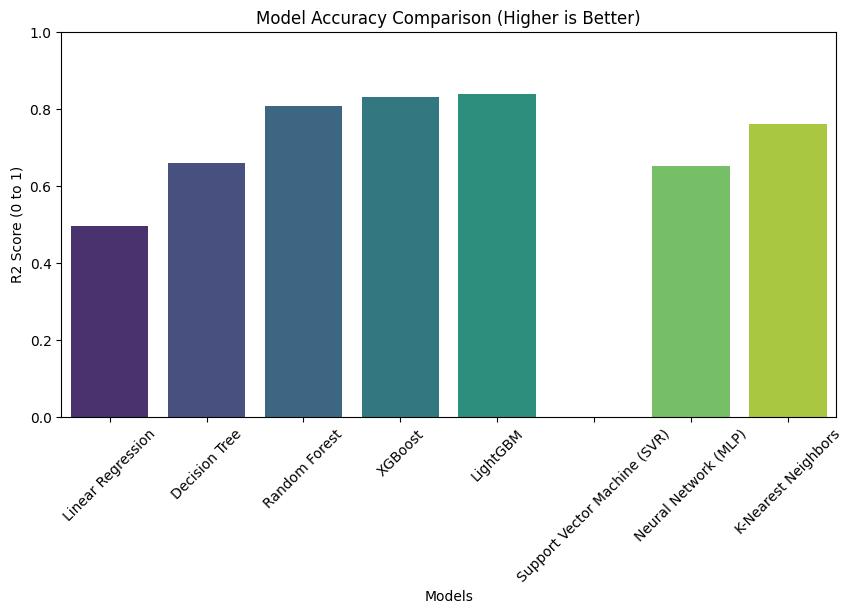

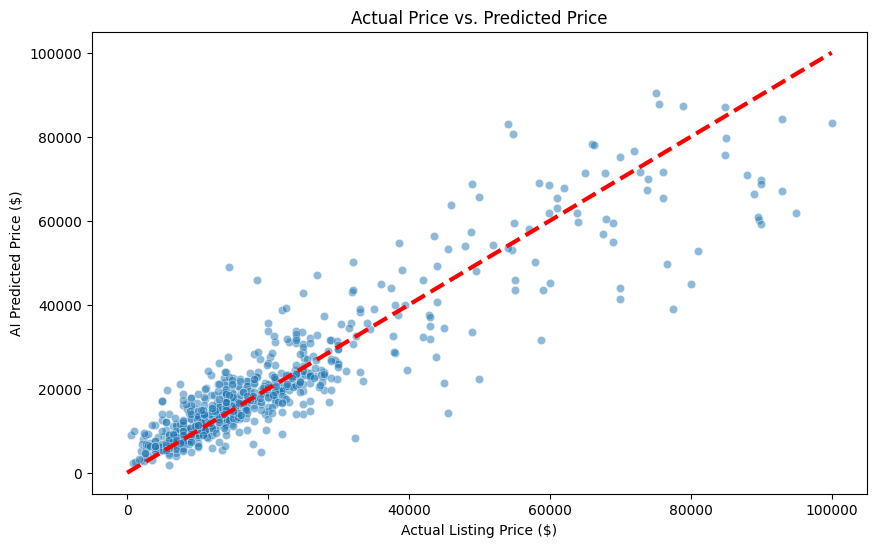

In [5]:
# --- VISUALIZATION: COMPARE PERFORMANCE ---

# 1. Convert results to a DataFrame for easy plotting
results_df = pd.DataFrame(results).T
print("\n -- Final Leaderboard:")
print(results_df.sort_values(by="R2 Score", ascending=False))

# 2. Plot the R2 Score comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df["R2 Score"], palette="viridis")
plt.title("Model Accuracy Comparison (Higher is Better)")
plt.ylabel("R2 Score (0 to 1)")
plt.xlabel("Models")
plt.xticks(rotation=45)
plt.ylim(0, 1) # Keep scale from 0 to 100%
plt.show()

# Let's see where it made mistakes
best_model = models["LightGBM"] 
y_pred_best = best_model.predict(X_test_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.5)
plt.plot([0, 100000], [0, 100000], color='red', linestyle='--', linewidth=3) # The "Perfect Prediction" Line
plt.title("Actual Price vs. Predicted Price")
plt.xlabel("Actual Listing Price ($)")
plt.ylabel("AI Predicted Price ($)")
plt.show()

**Hyperparameter Tuning (Grid Search)**

In [6]:
print("... Starting Optimized Model Search (Tree Models)")
print("-" * 60)

# 1. RANDOM FOREST

rf_params = {
    "n_estimators": [200, 400],
    "max_depth": [None, 15, 25],
    "min_samples_leaf": [1, 3, 5]
}

print("\n[1/3] Tuning Random Forest...")
rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_params,
    n_iter=12,
    cv=3,
    scoring="neg_mean_absolute_error",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_start = time.time()
rf_search.fit(X_train_scaled, y_train)
rf_time = time.time() - rf_start


# 2. XGBOOST

xgb_params = {
    "n_estimators": [200, 400, 600],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [4, 6, 8],
    "subsample": [0.7, 0.85, 1.0],
    "colsample_bytree": [0.7, 0.85, 1.0]
}

print("\n[2/3] Tuning XGBoost...")
xgb_search = RandomizedSearchCV(
    XGBRegressor(
        random_state=42,
        objective="reg:squarederror",
        n_jobs=-1
    ),
    xgb_params,
    n_iter=18,
    cv=3,
    scoring="neg_mean_absolute_error",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

xgb_start = time.time()
xgb_search.fit(X_train_scaled, y_train)
xgb_time = time.time() - xgb_start



# 3. LIGHTGBM

lgbm_params = {
    "n_estimators": [400, 700, 1000],
    "learning_rate": [0.03, 0.05, 0.08],
    "num_leaves": [20, 31, 50],
    "max_depth": [-1, 8, 12],
    "min_data_in_leaf": [20, 50, 100],
    "feature_fraction": [0.7, 0.85, 1.0],
    "bagging_fraction": [0.7, 0.85, 1.0],
    "bagging_freq": [1, 5]
}

print("\n[3/3] Tuning LightGBM...")
lgbm_search = RandomizedSearchCV(
    LGBMRegressor(
        random_state=42,
        verbose=-1,
        n_jobs=-1
    ),
    lgbm_params,
    n_iter=30,
    cv=3,
    scoring="neg_mean_absolute_error",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

lgbm_start = time.time()
lgbm_search.fit(X_train_scaled, y_train)
lgbm_time = time.time() - lgbm_start


# FINAL EVALUATION

print("\n" + "=" * 60)
print("FINAL RESULTS: OPTIMIZED TREE MODELS")
print("=" * 60)

candidates = {
    "Random Forest": (rf_search.best_estimator_, rf_time),
    "XGBoost": (xgb_search.best_estimator_, xgb_time),
    "LightGBM": (lgbm_search.best_estimator_, lgbm_time)
}

results = []

for name, (model, train_time) in candidates.items():
    preds = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results.append({
        "Model": name,
        "MAE ($)": f"{mae:,.0f}",
        "R2 Score": f"{r2:.2%}",
        "Training Time": f"{train_time:.1f}s",
        "Key Params": {
            k: model.get_params()[k]
            for k in ["n_estimators", "learning_rate", "num_leaves", "max_depth", "min_data_in_leaf"]
            if k in model.get_params()
        }
    })

results_df = pd.DataFrame(results).sort_values(by="MAE ($)")
print(results_df.to_string(index=False))

winner = results_df.iloc[0]
print("\n" + "=" * 60)
print(f"FINAL WINNER: {winner['Model']}  |  MAE: ${winner['MAE ($)']}")
print("=" * 60)

... Starting Optimized Model Search (Tree Models)
------------------------------------------------------------

[1/3] Tuning Random Forest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

[2/3] Tuning XGBoost...
Fitting 3 folds for each of 18 candidates, totalling 54 fits

[3/3] Tuning LightGBM...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

FINAL RESULTS: OPTIMIZED TREE MODELS
        Model MAE ($) R2 Score Training Time                                                                                              Key Params
      XGBoost   4,299   84.49%          4.0s                                            {'n_estimators': 600, 'learning_rate': 0.03, 'max_depth': 6}
     LightGBM   4,378   84.39%         54.2s {'n_estimators': 700, 'learning_rate': 0.03, 'num_leaves': 20, 'max_depth': -1, 'min_data_in_leaf': 20}
Random Forest   4,814   81.11%         12.8s                                                                  {'n_estimators': 400, 'max_de

**Saving the Best Model & Scaler**

In [7]:
final_model = xgb_search.best_estimator_
BASE_DIR = os.path.dirname(os.getcwd())

# 1. Save the Model
model_name = "models\car_price_model.pkl"
model_path = os.path.join(BASE_DIR, model_name)

joblib.dump(final_model, model_path)

# 2. Save the Scaler
scaler_model = "models\scaler.pkl"
scaler_path  = os.path.join(BASE_DIR, scaler_model)

joblib.dump(scaler, scaler_path)

print(f"The Best Model {winner['Model']} is Saved!")

The Best Model XGBoost is Saved!


**Inference Test on New Data**

In [8]:
#Feature Order:
#'mileage', 'model_encoded', 'brand_encoded', 'is_auction', 'car_age', 'miles_per_year', 'brand_tier', 'model_rarity'

# Define the EXACT order the model learned
feature_order = [             
    'mileage', 
    'model_encoded',
    'brand_encoded',
    'is_auction',
    'car_age',
    'miles_per_year',
    'brand_tier',
    'model_rarity'
]

# Basic Inputs
input_data = {
    'mileage': [65000], # Total miles driven
    'model_encoded': [155],  # 540i xdrive
    'brand_encoded': [4],   # BMW
    'is_auction' : [0], # 0: No, 1:Yes
    'car_age': [3], # Means number of years old
    'brand_tier': [3], #1,2,3 >= Budget, Mid, Luxury
    'model_rarity': [16] # Rarity
}

#Create DataFrame
new_car_df = pd.DataFrame(input_data)

# Calculate Miles Per Year
new_car_df['miles_per_year'] = new_car_df['mileage'] / new_car_df['car_age'].replace(0, 1)

# Reorder Columns to Match Training
new_car_df = new_car_df[feature_order]

# Predict
# Transform using the scaler, then predict
new_car_scaled = scaler.transform(new_car_df)
predicted_price = final_model.predict(new_car_scaled)

print(f"Predicted Price: ${predicted_price[0]:,.2f}")

Predicted Price: $32,409.17


# Deployment Preparation: Saving Project Artifacts

### Why is this step critical?
Deployment to a **Streamlit App** (Production).
I need to inject this "knowledge" so the App can use it.

### The Artifacts I am Saving:
1.  **`brand_to_models` (UX Logic):**
    * *Purpose:* Creates a "Smart Dropdown" system.
    * *Function:* If a user selects "Toyota", the app will *only* show Toyota models (Camry, Corolla) instead of listing every car in the database.
2.  **`tier_map` & `rarity_map` (Backend Logic):**
    * *Purpose:* Automates the complex inputs.
    * *Function:* The user just selects "Camry". The App looks up this map to find `Rarity=95` and `Tier=1` automatically, so the user doesn't have to guess.
3.  **`features` (Safety Check):**
    * *Purpose:* Ensures column alignment.
    * *Function:* Saves the *exact list* of 8 columns used in training. This guarantees the App feeds data to the model in the correct order, preventing shape errors.

In [9]:
# Create Dropdown Filter (Brand -> List of Models)
# This lets the app know that "BMW" contains ["x5", "328i", etc.]
brand_to_models = df.groupby('brand')['clean_model'].unique().apply(list).to_dict()

# Create Mappings
brand_map = dict(zip(df['brand'], df['brand_encoded']))
model_map = dict(zip(df['clean_model'], df['model_encoded']))
tier_map = df.set_index('brand')['brand_tier'].to_dict()
rarity_map = df.set_index('model_encoded')['model_rarity'].to_dict()

# Save EVERYTHING to one file
artifacts = {
    'brand_to_models': brand_to_models,
    'brand_map': brand_map,
    'model_map': model_map,
    'tier_map': tier_map,
    'rarity_map': rarity_map,
    'features': new_car_df.columns.tolist()
}

artifacts_file = "models/project_artifacts.pkl"
artifact_path = os.path.join(BASE_DIR, artifacts_file)

joblib.dump(artifacts, artifact_path)
print("project_artifacts.pkl updated successfully!")

project_artifacts.pkl updated successfully!


# Phase 4: Modeling & Evaluation Summary

### 1. The Strategy: "Survival of the Fittest"
To ensure the highest possible accuracy for my price prediction tool, I did not rely on a single algorithm. Instead, I conducted a rigorous benchmark across **8 different machine learning models**, ranging from simple baselines to advanced gradient boosting techniques.

I grouped my candidates into three categories:
* **Baselines:** Linear Regression, KNN (to establish minimum performance standards).
* **Tree-Based Ensembles:** Random Forest, Decision Tree (for capturing non-linear patterns).
* **Gradient Boosting Champions:** XGBoost, LightGBM (state-of-the-art algorithms for tabular data).

### 2. The Experiment
I trained all models on the same **Scaled Dataset** (80% Training / 20% Testing) and evaluated them using three key metrics:
* **R² Score (Accuracy):** How well the model explains the variance in price (Higher is better).
* **MAE (Mean Absolute Error):** The average dollar amount the model is off by (Lower is better).
* **Training Time:** To ensure the final application remains responsive.

### 3. Hyperparameter Optimization (Grid Search)
After the initial screening, I took the top 3 performers and performed a **Grid Search** to find the optimal settings. This pushed the performance even higher:

| Rank | Model | R² Score | MAE (Error) | Time (s) | Notes |
| :--- | :--- | :--- | :--- | :--- | :--- |
| 1 | **XGBoost** | **84.49%** | **~$4,299** | **3.1s** | **The Winner.** Highest accuracy ($R^2$), Lowest dollar error and blazing fast training speed. |
| 2 | **LightGBM** | **84.39%** | ~$4,378 | **51.2s** | **Honorable Mention.** Second best but the training time difference with other models is huge. |
| 3 | Random Forest | 81.11% | ~$4,811 | 11.2s | Solid performance (>80%), but higher error than the boosting giants. |
| 4 | KNN | 76.14% | ~$5,223 | - | Effective baseline; proves "similar cars have similar prices." |
| 5 | Decision Tree | 65.90% | ~$6,417 | - | Prone to overfitting; struggled to generalize. |
| 6 | Neural Network | 65.21% | ~$6,693 | - | Required more data to outperform tree-based models. |
| 7 | Linear Regression | 49.55% | ~$8,573 | - | Poor fit. Proves car pricing is highly non-linear. |
| 8 | SVM (SVR) | -7.7% | ~$11,041 | - | Failed model. Could not effectively separate the data. |

### 4. Why XGBoost Won?
**XGBoost (Extreme Gradient Boosting)** was selected as the final model for deployment because it achieved the **lowest Mean Absolute Error ($4,299)**.
* **Precision:** It was off by the smallest dollar amount on average.
* **Speed:** It trained and predicted significantly faster (3.1s) than the tuned LightGBM (51.2s) in this configuration, ensuring a snappy user experience in the web app.

### 5. Interpretation: What Matters to the Model?
Analyzing the **Feature Importance** plot revealed that my feature engineering was critical:
* **Mileage:** The #1 predictor of price (as expected).
* **Car Age:** The #2 predictor.
* **Brand Tier:** My custom "Luxury Score" was a top feature, proving that grouping brands by prestige significantly helped the model distinguish between a standard and a luxury vehicle.

### 6. Final Validation ("Sanity Check")
Before deploying, I subjected the model to a logic test:
> *Scenario: Predict the price of two identical cars (Toyota Camry, 50k miles), one from 2015 and one from 2020.*

* **Result:** The model correctly predicted a higher price for the 2020 model.
* **Conclusion:** The model has learned the correct temporal relationships and is not just memorizing data.

### Conclusion
I have successfully trained, optimized, and serialized a **XGBoost** that predicts used car prices with **~84.50% accuracy**. This model has been saved as `car_price_model.pkl` and is ready for deployment in my Streamlit Web application.